/home/lyy/miniconda3/envs/moco/lib/python3.10/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer
[2024/12/27 00:39:23][inr_train_20241227003923][DEBUG]logger inr_train_20241227003923 configuration done. Log file: exp/inr_train_20241227003923/train.log, Log level: 10, Console log level: 10, File log level: 20.
[2024/12/27 00:39:24][inr_train_20241227003923][DEBUG]|||||Trainer now using device: cuda:5|||||
[2024/12/27 00:39:24][inr_train_20241227003923][DEBUG]Total batches: train_loader 1 , val_loader 1, and epoch length is 100.
[2024/12/27 00:39:24][inr_train_20241227003923][DEBUG]|-
train:
  exp_name: inr
  batch_size: 1
  epoch: 3000
  learning_rate: 0.001
  device: cuda:5
  save_to: exp/inr_train_20241227003923
  loss_fn: |
    def loss_fn(pred

imshowing showset_before device: cuda:5


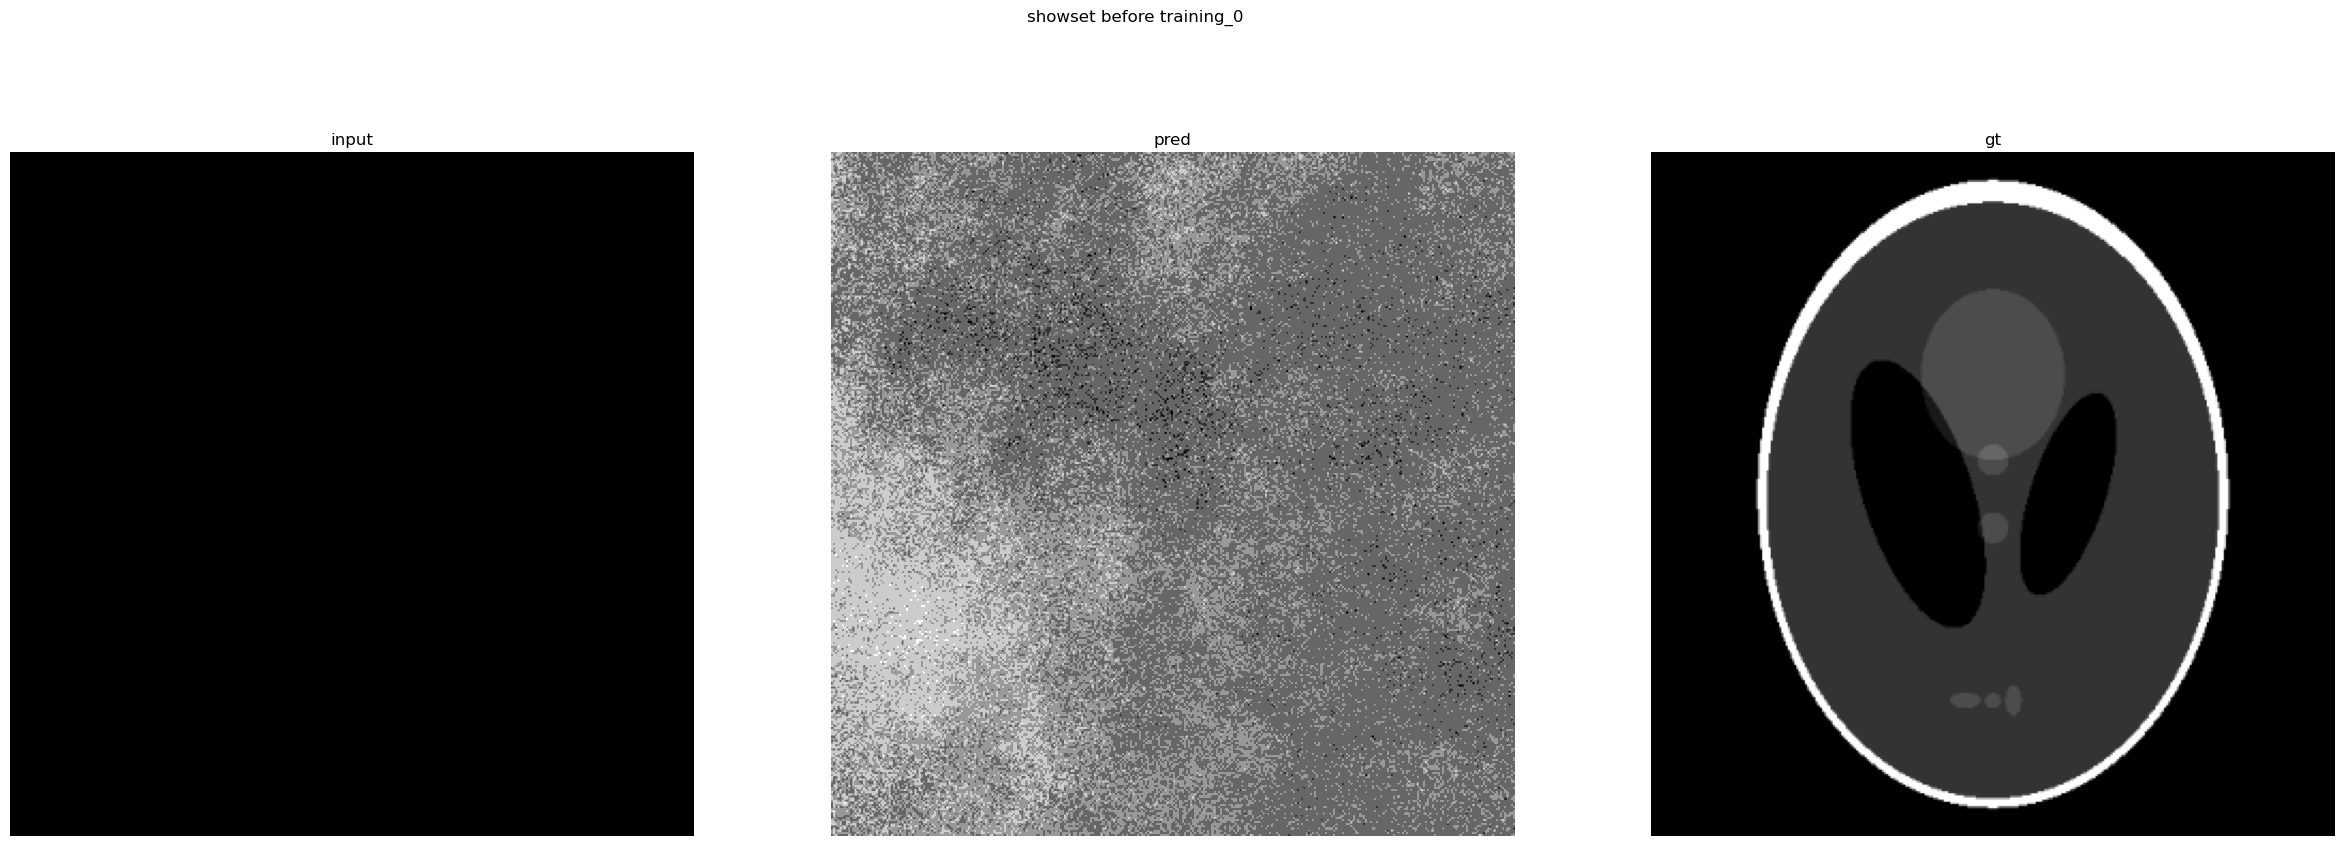

[2024/12/27 00:39:25][inr_train_20241227003923][INFO]Training started. Time: 2024-12-27 00:39:25.189317
[2024/12/27 00:39:25][inr_train_20241227003923][INFO]Early stopping is enabled. Early stopping metric: ssim, patience: 50, min_delta: 0.0001, after: 20
[2024/12/27 00:40:21][inr_train_20241227003923][DEBUG]Epoch[1/3000] run train evaluator.
[2024/12/27 00:40:21][inr_train_20241227003923][INFO]Training Results - Epoch[1/3000] ssim: 0.16325065644681058 psnr: 0.19435770000391395 loss: 0.9562340974807739
[2024/12/27 00:40:21][inr_train_20241227003923][DEBUG]Epoch[1/3000] run val evaluator.
[2024/12/27 00:40:22][inr_train_20241227003923][INFO]Validation Results - Epoch[1/3000] ssim: 0.16325065644681058 psnr: 0.19435770000391395 loss: 0.9562340974807739
[2024/12/27 00:40:22][inr_train_20241227003923][DEBUG]Epoch[1/3000] run tb_imshow_evaluator.
[2024/12/27 00:40:22][inr_train_20241227003923][DEBUG]Epoch[1/3000] tb_iter 1, run imshow_process.
[2024/12/27 00:41:19][inr_train_20241227003923][

imshowing testcase_trainset device: cuda:5


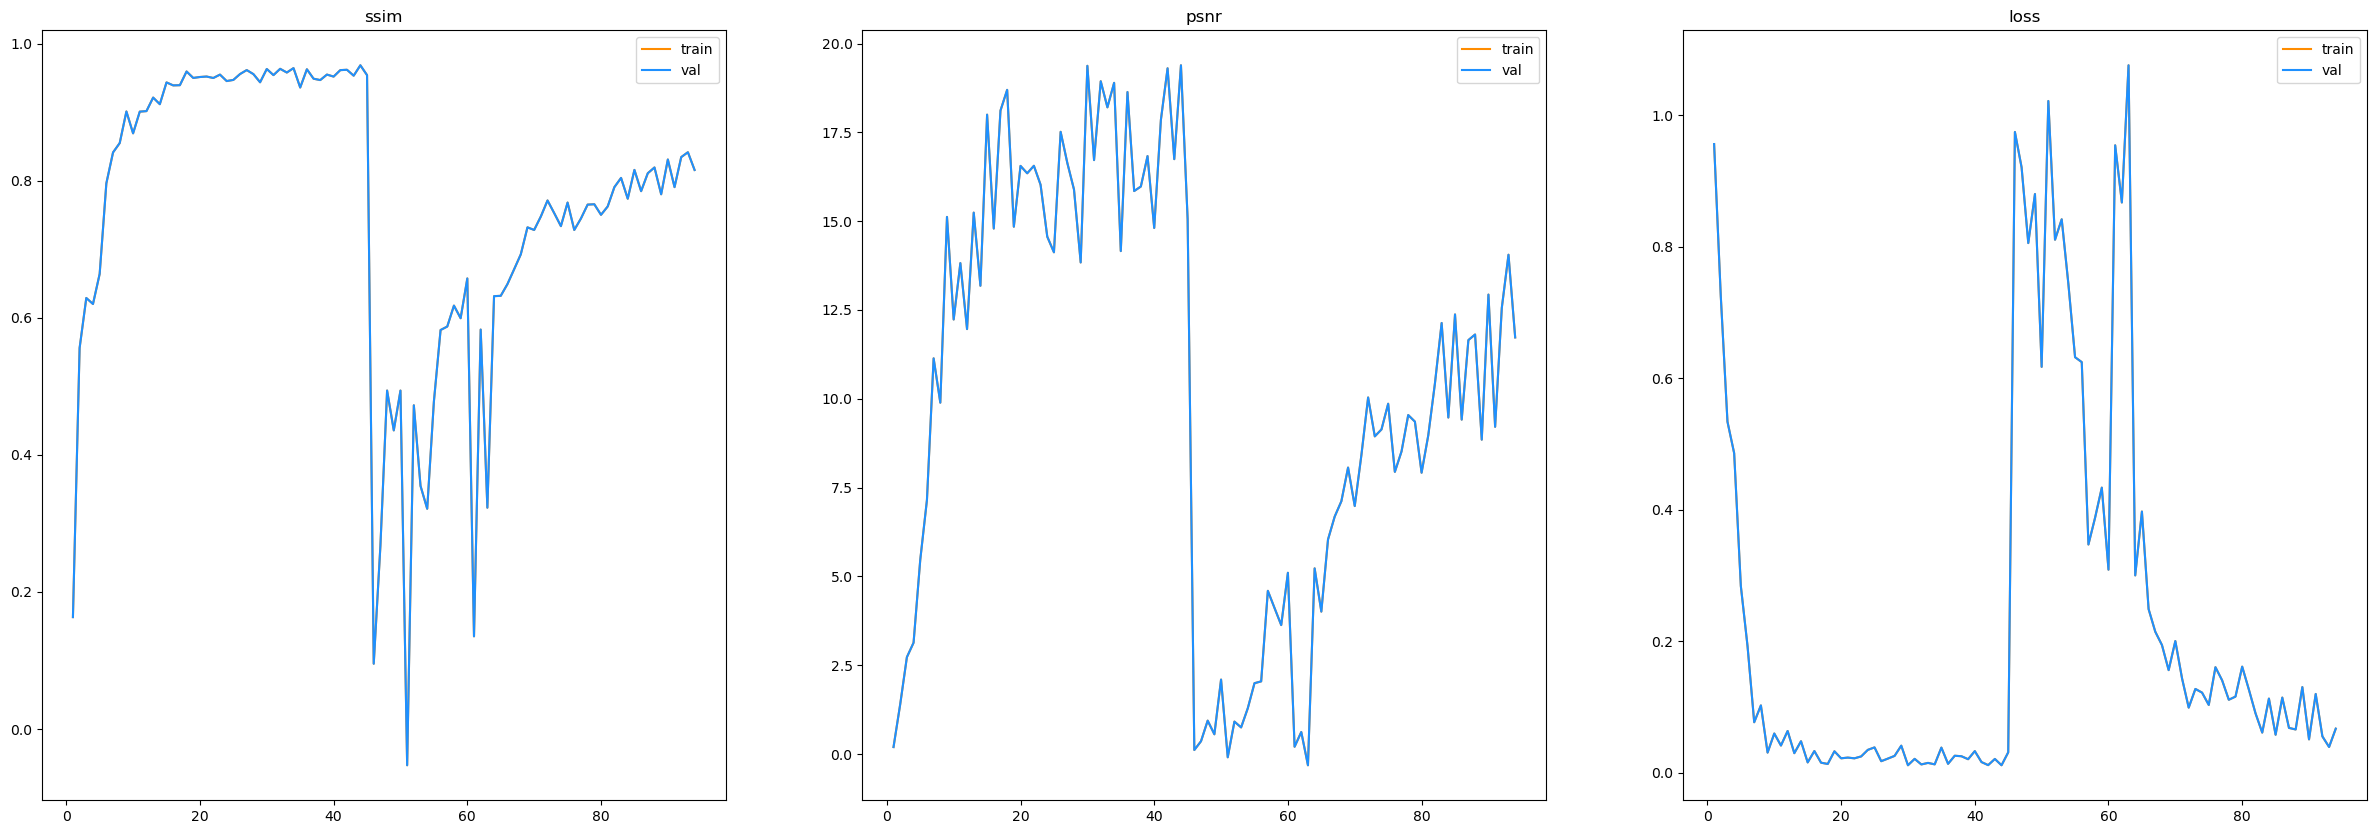

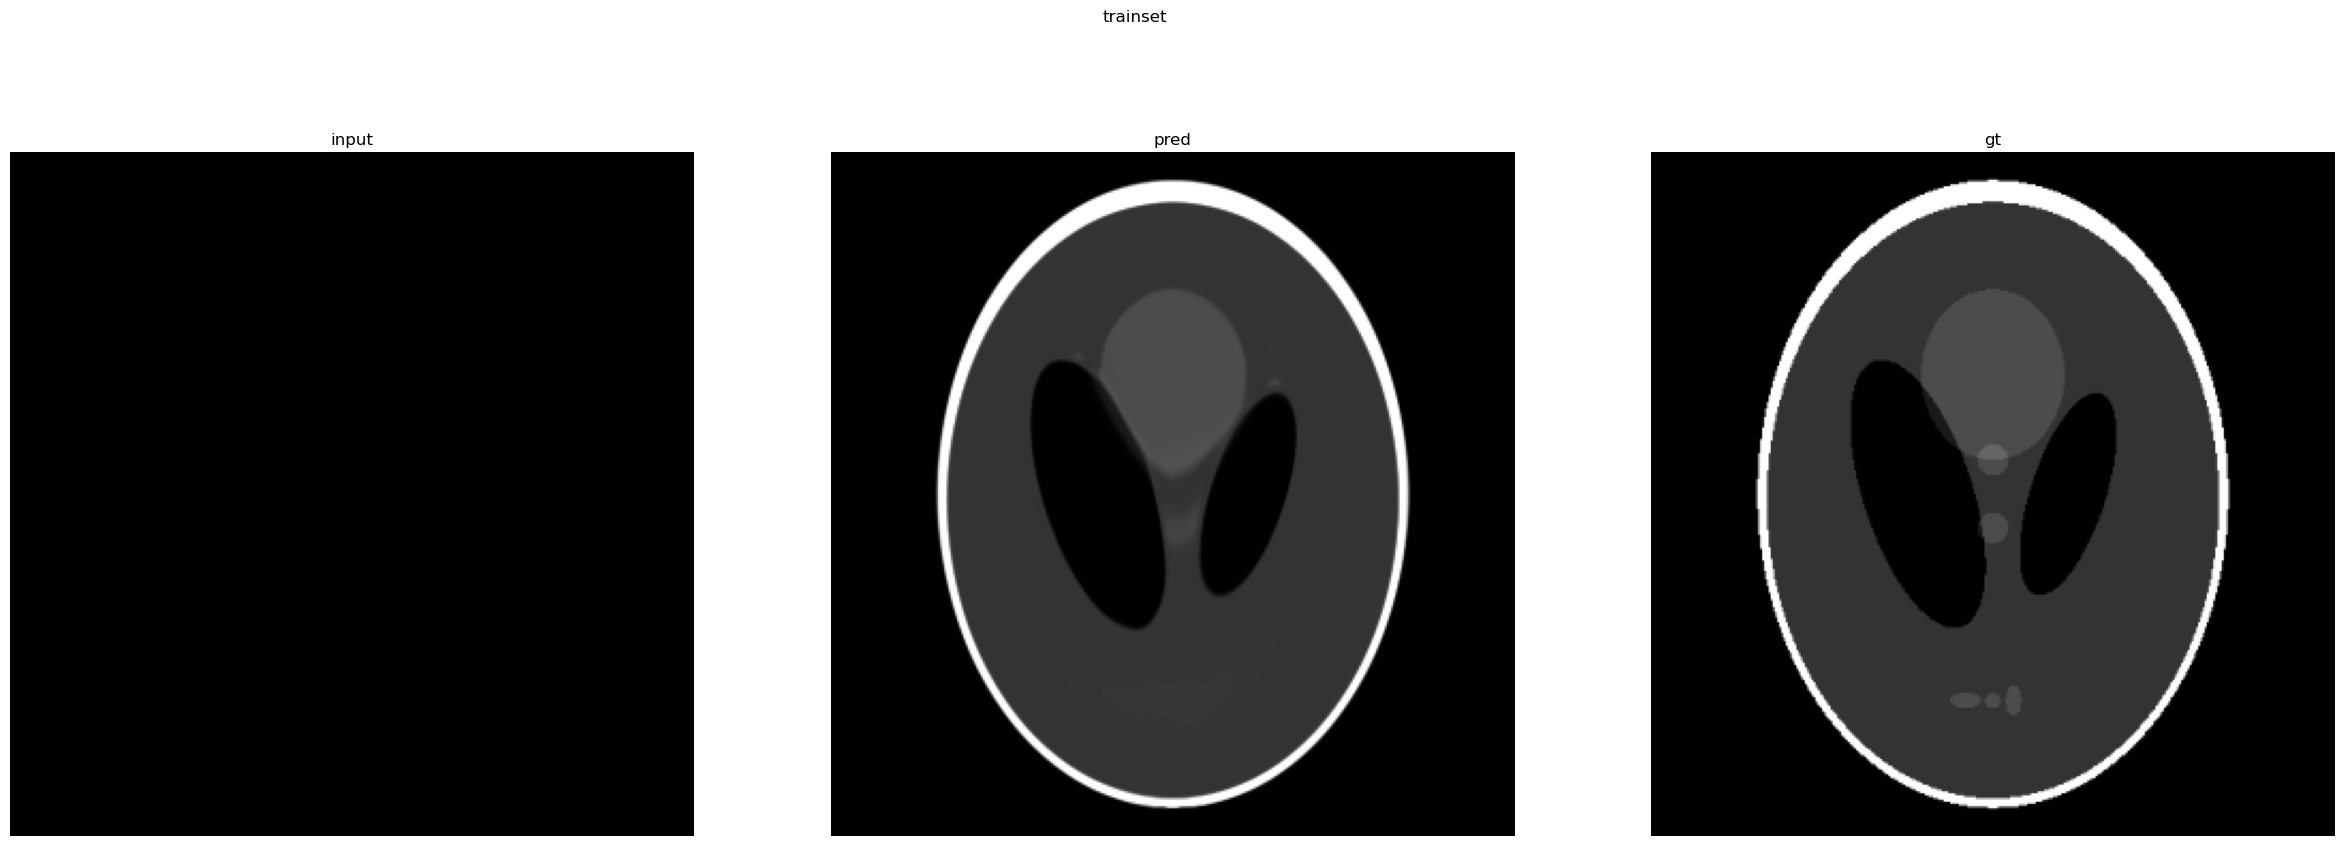

imshowing testcase_valset device: cuda:5


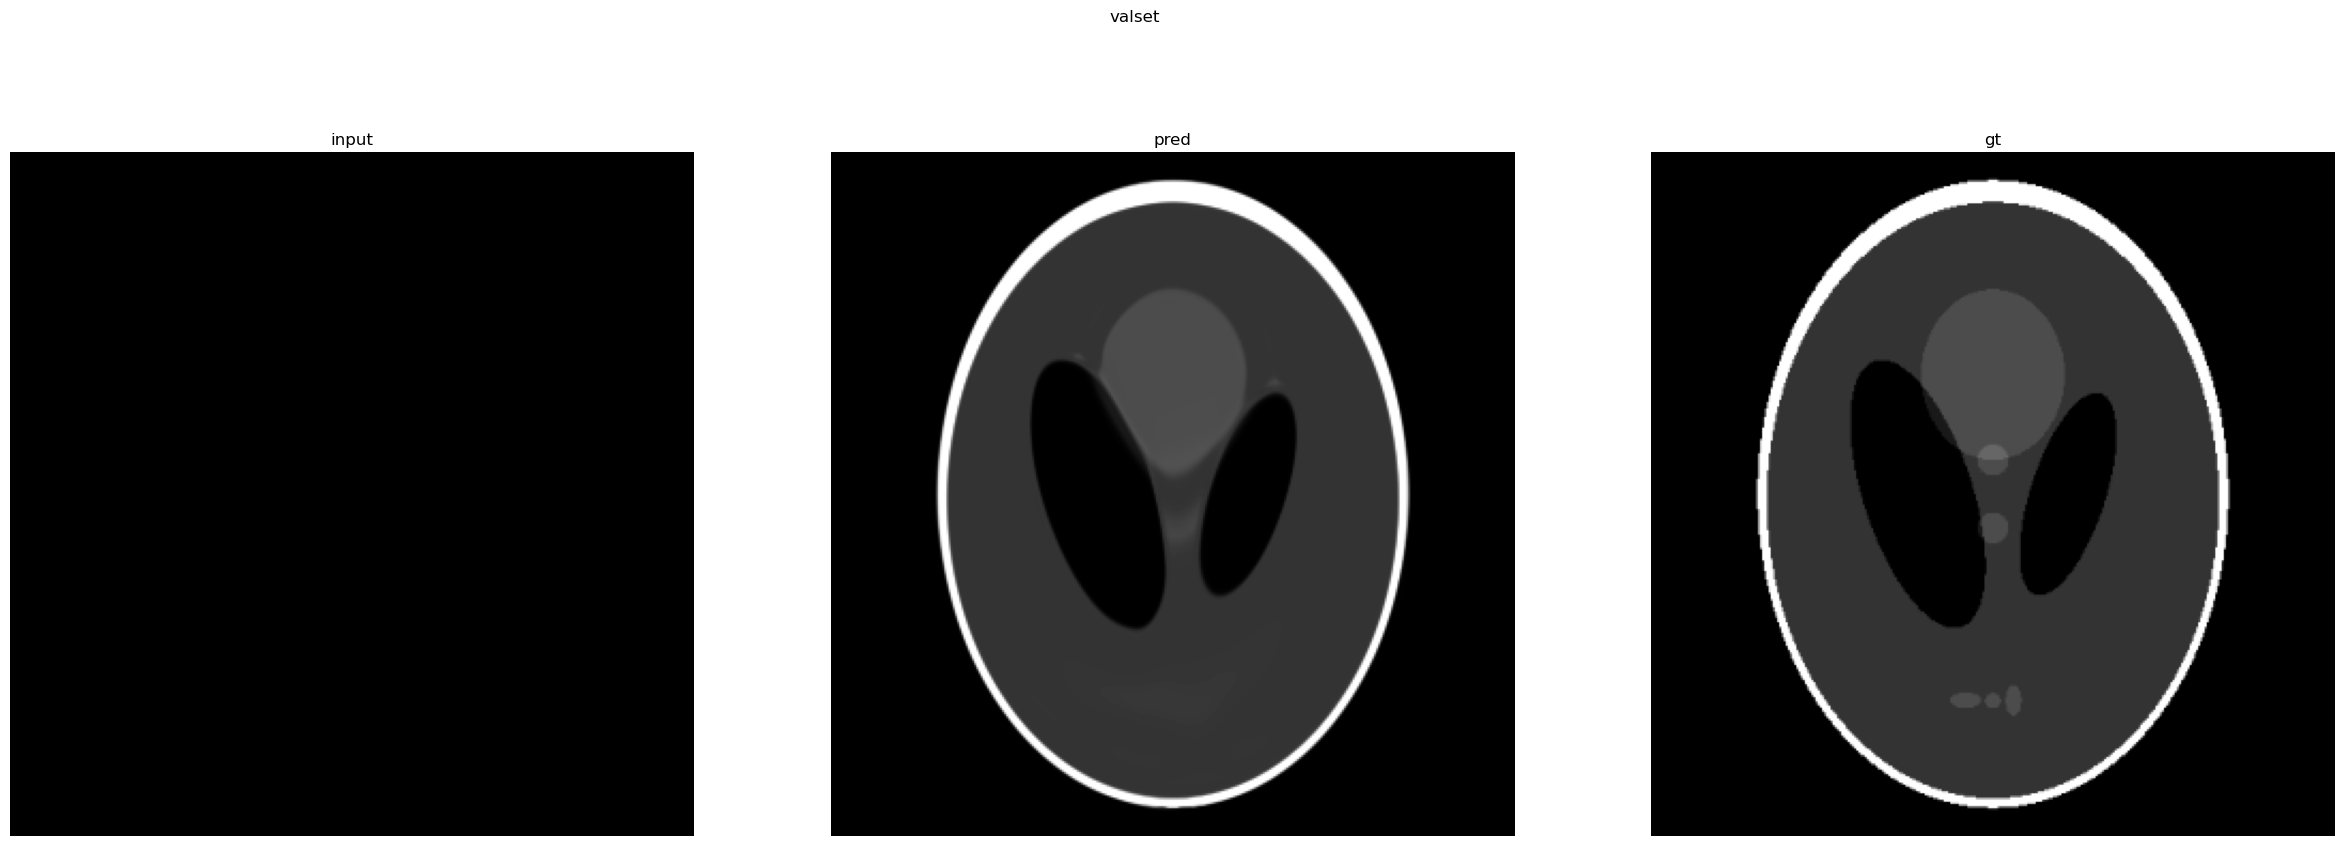

imshowing testcase_tb device: cuda:5


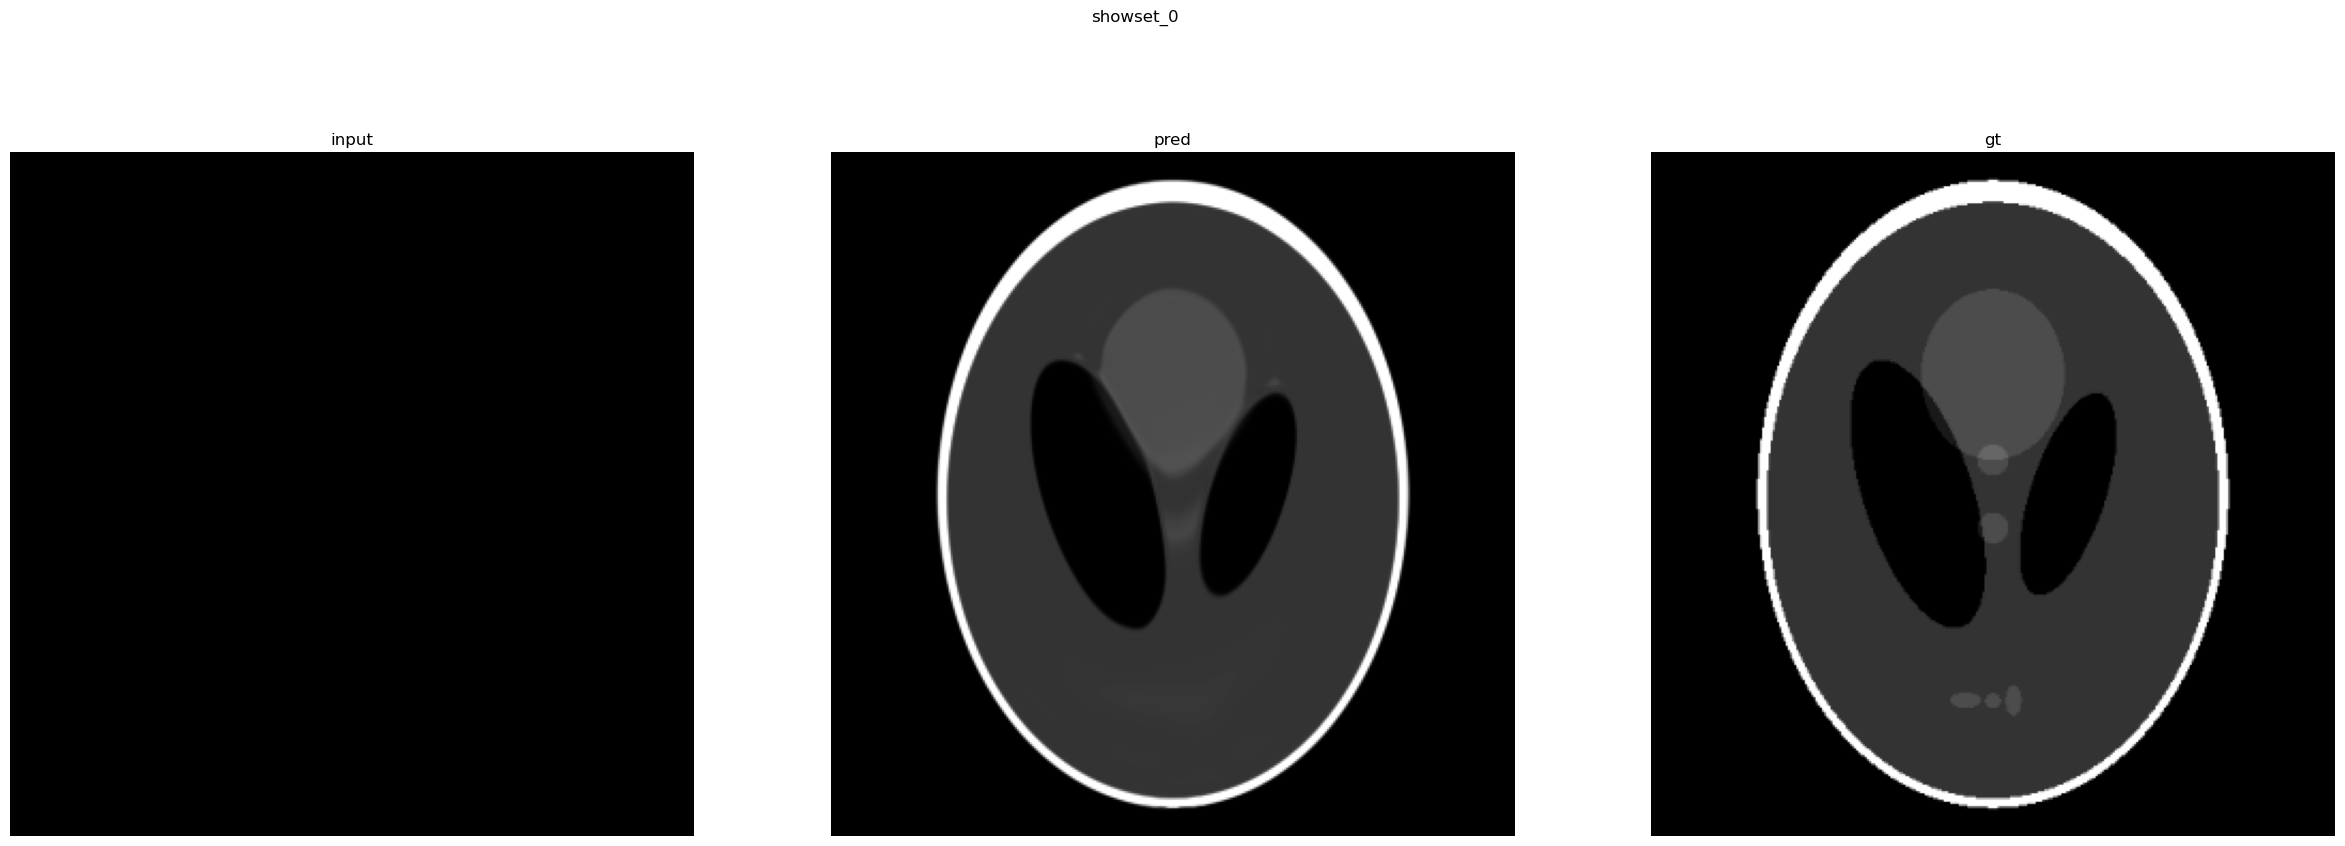

In [1]:
import torch
from torch import nn


class MyModel(nn.Module):
    def __init__(self, d_model = 1024, depth = 16):
        super().__init__()
        self.input_embedding = nn.Sequential(
            nn.Linear(2, d_model)
        )

        inr = nn.ModuleList()  # 使用 ModuleList
        for _ in range(depth):
            inr.append(nn.Linear(d_model, d_model))
            inr.append(nn.GELU())
        self.inr = nn.Sequential(*inr)

        self.output_embedding = nn.Sequential(
            nn.Linear(d_model, 1)
        )


    def forward(self, x):
        # b(1), seq, pos(h,w)
        x = self.input_embedding(x)
        x = self.inr(x)
        x = self.output_embedding(x)
        # b(1), seq, value(real)
        return x

from datasets import Phantom


trainset = Phantom(image_size = (320,320))

def create_posmap_normalized(height, width):
    """
    创建一个 (H, W, 2) 的坐标矩阵，每个坐标值归一化到 [-1, 1]。
    
    Args:
        height (int): 图像的高度 (H)
        width (int): 图像的宽度 (W)
    
    Returns:
        torch.Tensor: 大小为 (H, W, 2) 的归一化坐标矩阵
    """
    # 使用 meshgrid 创建网格
    y_coords, x_coords = torch.meshgrid(torch.arange(height), torch.arange(width), indexing="ij")
    
    # 将坐标转为浮点数
    y_coords = y_coords.float()
    x_coords = x_coords.float()
    
    # 归一化到 [-1, 1]
    x_coords = (x_coords / (width - 1)) * 2 - 1  # 将 x 坐标映射到 [-1, 1]
    y_coords = (y_coords / (height - 1)) * 2 - 1  # 将 y 坐标映射到 [-1, 1]
    
    # 堆叠坐标
    posmap = torch.stack((x_coords, y_coords), dim=-1)  # (H, W, 2)
    
    return posmap

def data_augmentation(data):
    image = data # b c h w
    image = (image - image.mean()) / image.std()

    b, c, h, w = image.shape
    # pos_map is a image of range(-1~1) * range(-1~1, w)
    pos_map = create_posmap_normalized(h, w).to(data.device)
    pos_seq = pos_map.view(h*w, 2).repeat(b*c, 1, 1)
    
    image_seq = image.view(b*c, h * w, 1)

    return {'value':image_seq, 'pos': pos_seq}

def input_transform(data):
    return data['pos'], data['value']

def metrics_transform(data):
    return data.view(1,1,320,320)

def show_transform(pred, gt, batch = None):
    if batch is None:
        return pred.view(1,1,320,320), gt.view(1,1,320,320)
    return pred.view(1,1,320,320), gt.view(1,1,320,320), torch.zeros(1,1,320,320)

def loss_fn(pred, true):
    return nn.functional.mse_loss(pred, true)

model = MyModel()

from train import train

train(model, trainset, loss_fn, epochs=3000, batch_size=1, device='cuda:5',exp_name="inr", early_stopping_patience=50,early_stopping_after=20,
      epoch_length=100, eval_length_train = 1, eval_length_val = 1, input_transform=input_transform,augmentation_transform=data_augmentation,show_transform=show_transform,metric_transform=metrics_transform,
      val_dataset=trainset,
      imshow_dataset=trainset)